In [1]:
import numpy as np
import os
import datetime 

# Tao
from pytao import Tao

#BO
from bayes_opt import BayesianOptimization

# openPMD-beamphysics
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import twiss_match, matched_particles
from pmd_beamphysics.statistics import slice_statistics, twiss_dispersion_calc
from pmd_beamphysics.plot import slice_plot, marginal_plot, density_and_slice_plot
from h5py import File

# FEL parametrization
from fel_mx_model import resonantLambda, rhoFEL, gainLength1D, getLambdaMX, gainLength,\
                         Pbeam, Psat, Pz, shot_noise

# LCLS and physics params
from constants import m_e, e, c, hc, markers, z, K_u, lambda_u, I_A

# nicer plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)
plt.rcParams.update({'font.size': 14})

# useful for debugging
%load_ext autoreload
%autoreload 2

# Run Tao and get beam data

In [2]:
init = '-init ./tao.init -noplot'
# Make tao instance
tao=Tao(init)   

In [4]:
%%tao
snparticle 100
beamon
set ele CE11 x1_limit = 0.0015 ;set ele CE11 x2_limit = 0.0035

-------------------------
Tao> snparticle 100


RuntimeError: Command: snparticle 100 causes error: ERROR detected: [ERROR | 2021-AUG-15 18:59:29] calc_emittances_and_twiss_from_sigma_matrix:
    CANNOT NORMALIZE EIGENVECTORS.
[ERROR | 2021-AUG-15 18:59:29] tao_beam_track:
    Singular sigma matrix is:
        7.8458568E-10 -1.5039362E+10 -1.0774307E-10 -2.6331985E+10  7.1257270E-12  5.7233700E+15
       -1.5039362E+10  5.3583048E+30  2.8692555E+10  1.3284498E+31 -7.4791047E+08 -2.1016460E+36
       -1.0774307E-10  2.8692555E+10  9.2600407E-10  7.4195201E+10 -4.1245300E-12 -1.2272473E+16
       -2.6331985E+10  1.3284498E+31  7.4195201E+10  3.7970392E+31 -7.7291338E+09 -5.4113859E+36
        7.1257270E-12 -7.4791047E+08 -4.1245300E-12 -7.7291338E+09  8.0337146E-11  6.9814913E+13
        5.7233700E+15 -2.1016460E+36 -1.2272473E+16 -5.4113859E+36  6.9814913E+13  8.6862945E+41
    Will not print any more singular sigma matrices for this track...
13 particle(s) lost at element 2825: PSHXH45#2  Total lost: 74  of 100
2 particle(s) lost at element 2832: UMAHXH46#1  Total lost: 76  of 100
6 particle(s) lost at element 2978: BYD1  Total lost: 82  of 100
1 particle(s) lost at element 2980: BYD2  Total lost: 83  of 100
1 particle(s) lost at element 2982: BYD3  Total lost: 84  of 100
15 particle(s) lost at element 2984: PCPM1L  Total lost: 99  of 100
Total number of lost particles by the end of universe  1:    99.

In [1]:
#timestamp = '07-07_10-30'
timestamp = '08-08_10-30'

In [72]:
def saveBeam():
    timestamp = (datetime.datetime.now()).strftime("%m-%d_%H-%M")
    
    # need to log settings for bmad somewhere here?

    # write beam at each marker in undulator
    for i,marker in enumerate(markers):
        tao.cmd(f'write beam -at {marker} ./beam_undulator_data/lcls_beam_{i}_{marker}_{timestamp}.h5')
    return timestamp

In [5]:
beamOn(5000)
#timestamp = saveBeam()

RuntimeError: Command: snparticle 5000 causes error: ERROR detected: [ERROR | 2021-AUG-13 05:40:36] tao_command:
    UNRECOGNIZED COMMAND: snparticle 5000

# Import data and slice beam bunches 

In [77]:
# create ParticleGroup from bmad h5 particle data
directory = './beam_undulator_data/'

def importData(timestamp):
    # Beam data along undulator
    P_data= {}

    for i,marker in enumerate(markers):
        filename = f'lcls_beam_{i}_{marker}_{timestamp}.h5'
        P_data[f'{marker}'] = ParticleGroup(directory+filename)   
        
    # collimation loses some particles, take only alive particles here
    for beam in P_data:
        P_data[beam] = P_data[beam].where(P_data[beam].status==1) # status 1 is alive
        n_part_alive = P_data[beam].n_alive
    return P_data, n_part_alive

In [6]:

n_part_alive

3807

In [84]:
def test():
    global zucchini
    zucchini = 1

zucchini

NameError: name 'zucchini' is not defined

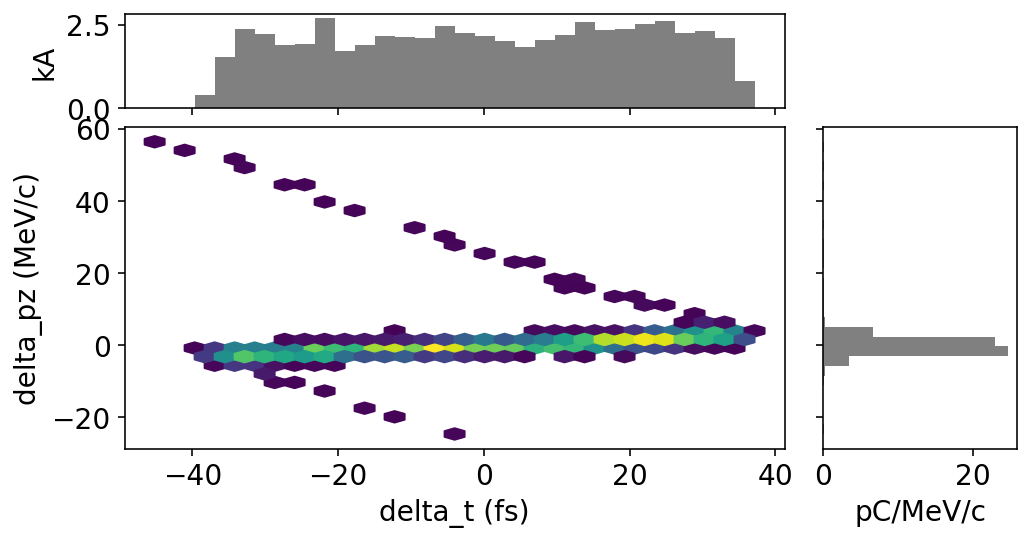

In [7]:
P_data['VVHXU19'].plot('delta_t', 'delta_pz')

In [8]:
slices = {}
n_slice = int(n_part_alive/)

## getting sliced stats for beam at each marker (along z)
for i,marker in enumerate(markers):
    P = P_data[f'{marker}'] 
    slices[marker] = slice_statistics(P, \
                            keys=["sigma_pz","mean_pz","average_current","norm_emit_x","norm_emit_y",\
                                  "mean_px", "mean_x", "mean_py", "mean_y", "sigma_x", "sigma_y"], \
                            n_slice= n_slice, slice_key='t')

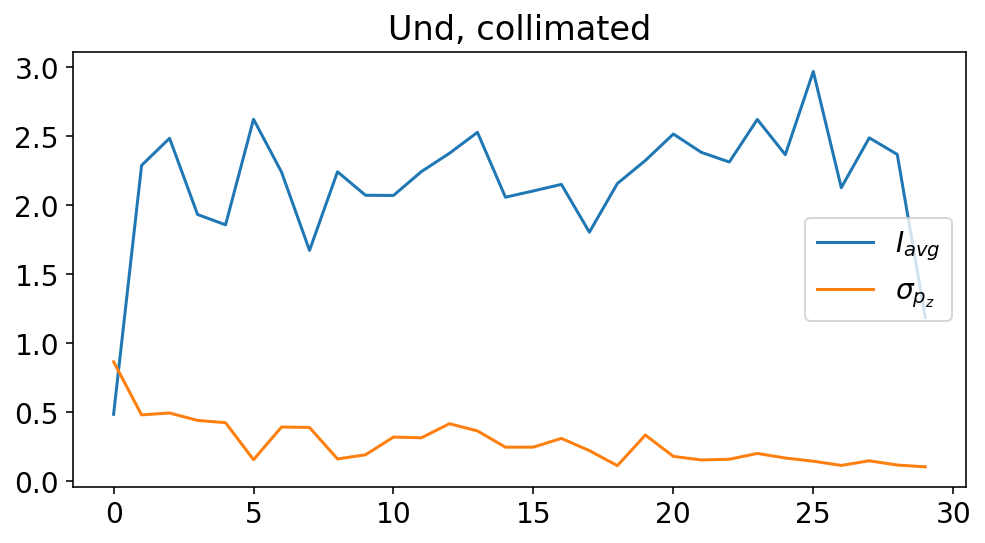

In [12]:
#fig, ax = plt.subplots(3, sharex=True, figsize=(10,13))
sl = slices["VVHXU19"]

#plt.plot(sl['norm_emit_x']*10**(9), label=r"$\epsilon_x$")
#plt.plot(sl['norm_emit_y']*10**(9), label=r"$\epsilon_y$")
plt.plot(sl['average_current']*10**(-3), label=r"$I_{avg}$")
plt.plot(sl['sigma_pz']*10**(-7), label=r"$\sigma_{p_z}$")
plt.title("Und, collimated")

plt.legend()

#plt.ylim(0,5)
### energy spread is large because of the weird line shaped horns

In [17]:
time_slice = (P.t.max()-P.t.min())/n_slice

## Find 3D gain length

In [56]:
# instant growth rate (Lg) at each marker for each slice
lg_slice = []

for i,marker in enumerate(markers):
    
    # particle group/slice
    sl = slices[marker]
    P = P_data[marker] 

    # emittances
    norm_emit_x = sl["norm_emit_x"]
    norm_emit_y = sl["norm_emit_y"]
    
    # average current
    current_beam = sl["average_current"]
    #current_beam = 3*1e3 if sl["average_current"][i]>3*1e3 else sl["average_current"][i]

    # energy spread
    sig_pz = sl["sigma_pz"]/19 # adjusted just to test, take real one here after fixing horns!!!!!!!!!!!!!
    #sig_pz = [0.5*1e7 if x>0.5*1e7 else x for x in sl["sigma_pz"]] # adjusted just to test, take real one here after fixing horns!!!!!!!!!!!!!
    mean_pz = sl["mean_pz"]

    # gamma relativistic
    gamma_beam = sl["mean_pz"]/P.mass 
    
    # normalization factor for each slice ---> is this correct or is it beta*gamma?????????????????????
    norm_fac_mult = gamma_beam 

    # unnormalized emittances
    un_emit_x = norm_emit_x/norm_fac_mult # [m]
    un_emit_y = norm_emit_y/norm_fac_mult
    
    # beam sizes
    sig_x = sl["sigma_x"]
    sig_y = sl["sigma_y"]

    # geom size
    sizes = np.sqrt(sig_x*sig_y) #check for MX assumptions: assymmetric beam size?????????????????????
    
    # geom emittance (not normalized)
    emittance = np.sqrt(un_emit_x * un_emit_y)

    # radiation wavelength
    lambda_rad = resonantLambda(gamma_beam, K_u, lambda_u)
    
    # FEL parameter
    rho = rhoFEL(current_beam, sizes, gamma_beam)
    
    # get instant. Lg
    Lg1D = gainLength1D(rho, lambda_u)
    
    # Ming Xie
    LambdaMX = getLambdaMX(Lg1D, sizes, lambda_rad, emittance, lambda_u, sig_pz, mean_pz)
    Lg = gainLength(Lg1D, LambdaMX)
    
    # append to list
    lg_slice.append(Lg)

### Find z location reached 18Lg

In [57]:
# Get z distance between markers (dZ)
dZ = [0]*len(z)

for i,loc in enumerate(z):
    dz = loc-z[i-1]
    
    if dz == 0 or i ==0:
        dz = 0 
    dZ[i] = dz

In [58]:
lg_cumul_slice = [] # gain lengths so far for each slice
zsat = [] # z at saturation
zsat_idx = [] # index of z list at saturation

for j in range(n_slice):
    fracLgcum = 0
    satQ = False
    list_lg_cum = [] # for each slice get Lg along z
    
    for i, instLg in enumerate(lg_slice):
        # at this location in und, get number of gain lengths so far
        fracLg = dZ[i]/instLg[j] # dist since last marker in fractions of Lg at this marker
        Lgcum = fracLg + fracLgcum # increment to find 18Lg marker location
        fracLgcum = Lgcum
        list_lg_cum.append(Lgcum)
        
        if fracLgcum > 18 and satQ == False:
            satQ = True
            #print(f"saturated at z = {z[i]}, marker = {markers[i]}")
            zsat.append(z[i])
            zsat_idx.append(i)
            
    lg_cumul_slice.append(list_lg_cum)

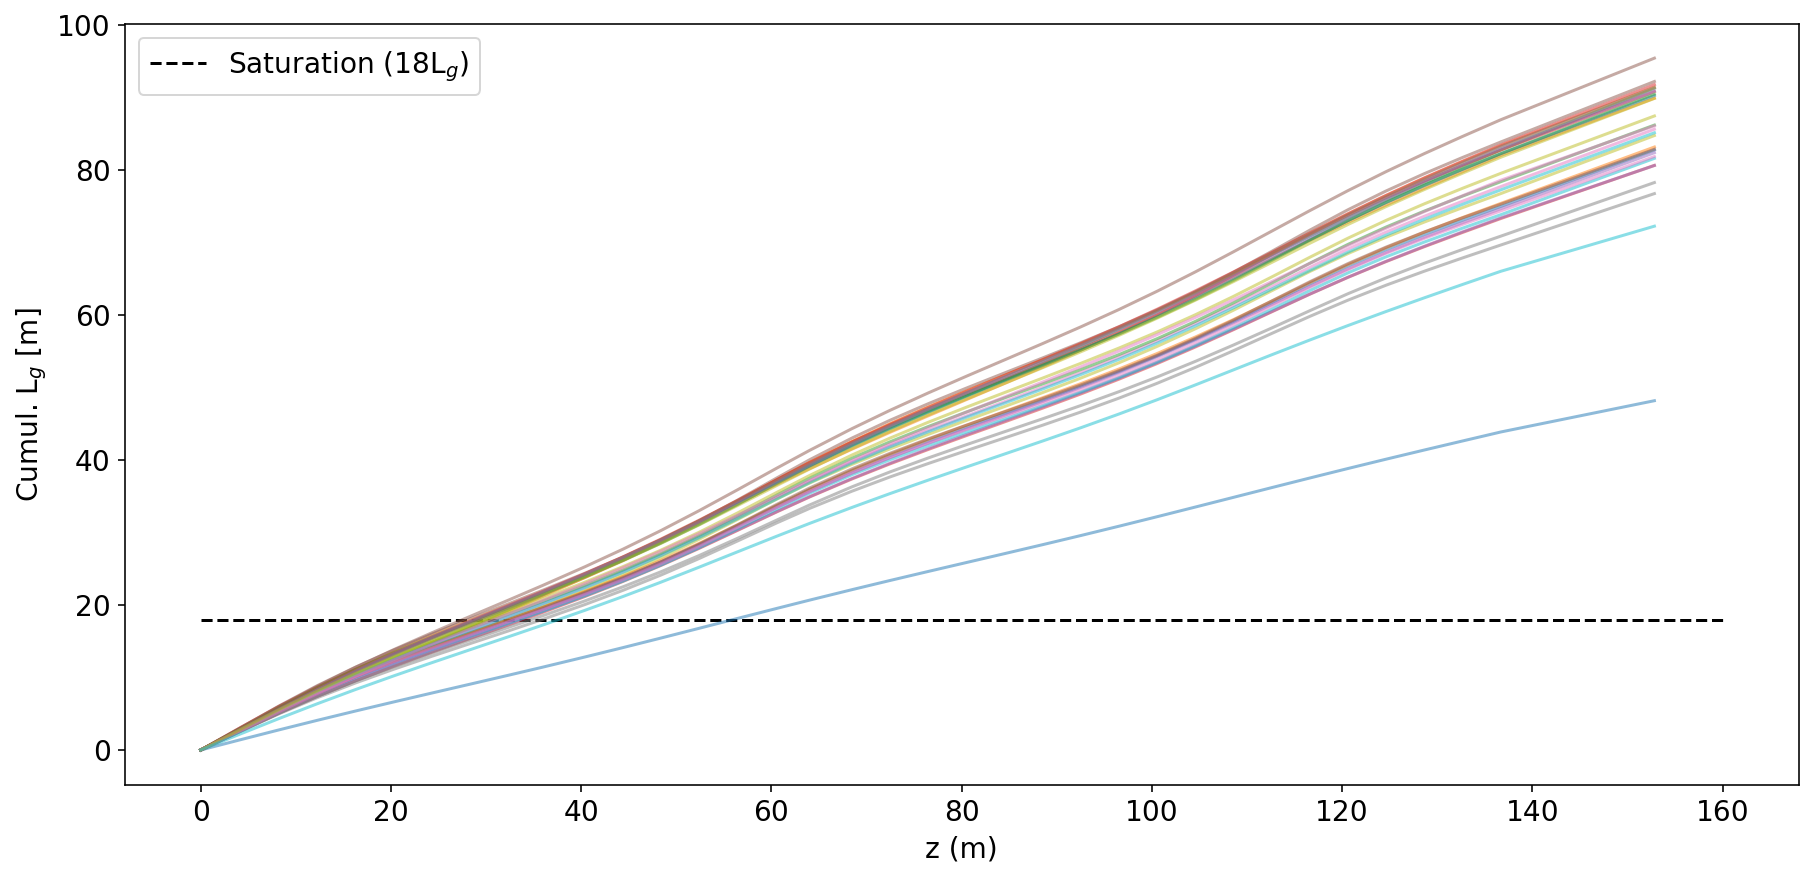

In [59]:
plt.figure(figsize=(15,7))

for i in range(n_slice):
    # plot cumulative Lg for each slice along undulator
    plt.plot(z, lg_cumul_slice[i], alpha=0.5)

# saturation point
plt.hlines(18, 0, 160, linestyle="--", color="black", label="Saturation (18L$_g$)")

plt.legend()
plt.ylabel(r"Cumul. L$_g$ [m]");
plt.xlabel("z (m)");

### Find saturation power

In [60]:
# get avg Lg for each slice from saturation point
lg_avg = []

#for i in range(n_slice): # SOME DON'T SATURATE HERE
for i in range (len(zsat)):
    lg_avg.append(zsat[i]/18) # wait is this correct?
    
p_shotnoise_list, rho_list, psat_list, mean_pz_list, current_list, sizes_list, lambda_rad_list = \
[], [], [], [], [], [], []

# loop over slices at the point where each saturates
for i in range(n_slice):
    # z along und where saturation happens
    sl = slices[markers[zsat_idx[i]]]
    P = P_data[markers[zsat_idx[i]]]

    # emittances
    norm_emit_x = sl["norm_emit_x"][i]
    norm_emit_y = sl["norm_emit_y"][i]
    
    # average current
    #current_beam = sl["average_current"][i]
    current_beam = 3*1e3 if sl["average_current"][i]>3*1e3 else sl["average_current"][i]

    current_list.append(current_beam)

    # energy spread
    sig_pz = sl["sigma_pz"][i]/19 # need to adjust later !!!!!!!!!!!!!!!!!!!!!!
    #sig_pz = 0.5*1e7 if sl["sigma_pz"][i]>0.5*1e7 else sl["sigma_pz"][i]
    mean_pz = sl["mean_pz"][i]
    mean_pz_list.append(mean_pz)
    
    # gamma relativistic
    gamma_beam = sl["mean_pz"][i]/P.mass 
    
    # unnormalized emittances
    un_emit_x = norm_emit_x/norm_fac_mult[i] # [m]
    un_emit_y = norm_emit_y/norm_fac_mult[i]
    emittance = np.sqrt(un_emit_x * un_emit_y)
    
    sig_y = sl["sigma_y"][i]
    sig_x = sl["sigma_x"][i]

    
    sizes = np.sqrt(sig_x*sig_y)
    sizes_list.append(sizes)
    
    # get inst Lg
    lambda_rad = resonantLambda(gamma_beam, K_u, lambda_u)
    lambda_rad_list.append(lambda_rad)
    
    rho = rhoFEL(current_beam, sizes, gamma_beam)
    rho_list.append(rho)
    Lg1D = gainLength1D(rho, lambda_u)
    
    p_shotnoise_list.append(shot_noise(rho, lambda_rad, current_beam, gamma_beam))
    pbeam = Pbeam(gamma_beam, current_beam)
    
    # not sure if correct to us 3DLg in MX factor?
    LambdaMX = getLambdaMX(lg_avg[i], sizes, lambda_rad, emittance, lambda_u, sig_pz, mean_pz)
    Lg = lg_avg[i]
    
    psat_list.append(Psat(LambdaMX, rho, pbeam)) # in GW
    print(Psat(LambdaMX, rho, pbeam), current_beam/1e3, Pz(shot_noise(rho, lambda_rad, current_beam, gamma_beam), 18))

1.973857033328113 0.484224716258557 5.803344372803486
19.41691890007244 2.2867815260465436 12.50589241663181
21.21020655146075 2.4829012380500894 12.248980684061692
14.25281266226781 1.930921406644222 8.97516096123975
13.681948455494497 1.8560665639572698 9.060940405586216
21.949812716889287 2.6207315827771116 10.466523987420205
17.376593902867167 2.2382200159403323 9.28648533394098
11.59376808949132 1.671021849648491 7.710435891701824
16.997226899589265 2.240261075099321 8.620536279160369
15.016279016778187 2.0703835002538544 8.069019072284917
15.253814419234159 2.0689278603106307 8.527547912787837
16.740501191142968 2.2420435203082425 8.676207667495712
18.254370739533265 2.3742454049089075 8.815738761810783
20.37895217289478 2.5258423897174747 9.90239868440261
15.305805196889724 2.0564938847294068 8.847462039756314
15.273279263327481 2.10176164334412 8.049338667135457
15.583823444200796 2.1492882008738814 7.987744568505502
12.668445058812535 1.8031638365795652 7.7423207480434115
16.9

In [61]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,20), (20, 40), (40, 60)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1

In [62]:
min_e = min(mean_pz_list)
max_e = max(mean_pz_list)
(max_e - min_e)/np.mean(mean_pz_list)*100
min_e, max_e, (max_e-min_e), int((max_e-min_e))#/bin_size)

(7975805497.008093, 7981209108.343141, 5403611.335047722, 5403611)

In [63]:
bin_size = 500000
bins = create_bins(lower_bound= int(min_e),
                       width=bin_size,
                       quantity= int((max_e-min_e)/bin_size))

In [67]:
import scipy.constants as constants

binned_psat = [0]*len(bins)
binned_e_phot = [0]*len(bins)
binned_num_phot = [0]*len(bins)
en_idx = []

for i in range(n_slice):
    # find e- energy bin index
    bin_index = find_bin(mean_pz_list[i], bins)
    en_idx.append(bin_index)

    # increment Psat val at that bin index [JOULES]
    binned_psat[bin_index] = binned_psat[bin_index] + psat_list[i]*time_slice*1e9 ## IN JOULES, from W not GW
    
    # photons/sec from power: divide by photon energy [W]/[J]= ph/[s]
    # need photon energy corresponding to each electron energy bin
    
    
#     binned_e_phot = constants.h*c/(lambda_rad_list[i]) # [J.s]x[m/s]/m
#     binned_num_phot[bin_index] = binned_psat[bin_index] / binned_e_phot + binned_num_phot[bin_index]
#     #binned_num_phot[bin_index] = binned_e_phot/constants.h + binned_num_phot[bin_index]
    

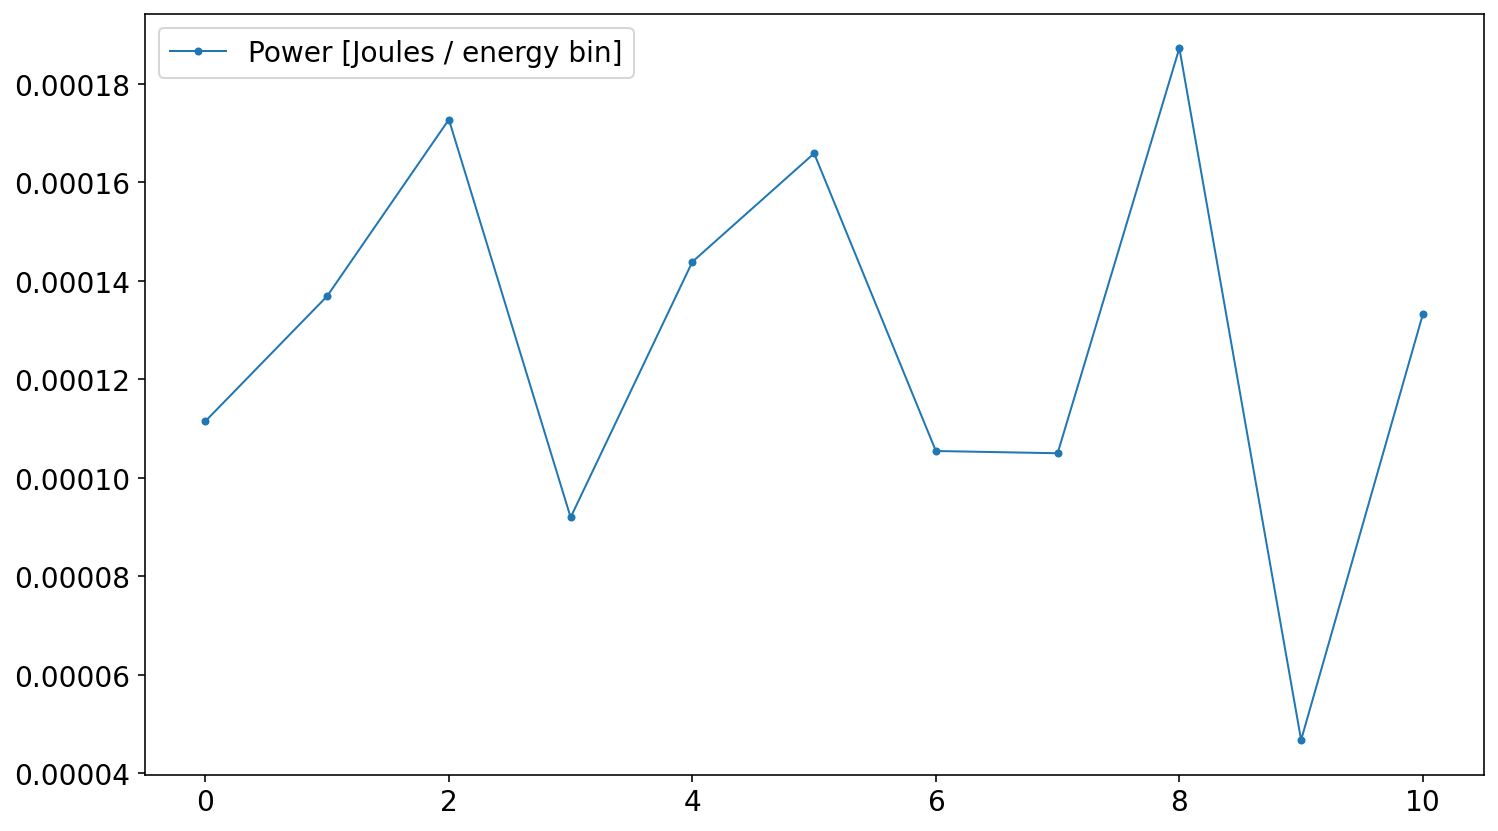

In [68]:
plt.figure(figsize=(12,7))

plt.plot(binned_psat, linewidth=1, marker='.', label="Power [Joules / energy bin]")
#plt.ylabel("P/energy bin [GW]")

#plt.plot(en_idx, np.array(current_list)/50, linewidth=0, marker='o', markersize=2, label="Current [kA/50]")
#plt.plot(en_idx, np.array(psat_list), linewidth=0, marker='x', label="Psat [GW]")

plt.legend()

#plt.ylim(0,2000)
#plt.plot(np.array(binned_num_phot)/1, linewidth=0, marker='x', markersize=5)

# max 0.6-1.3 E17 photons/pulse -> expected 0.15-14 E12 ---->>> 5 orders of magnitude off

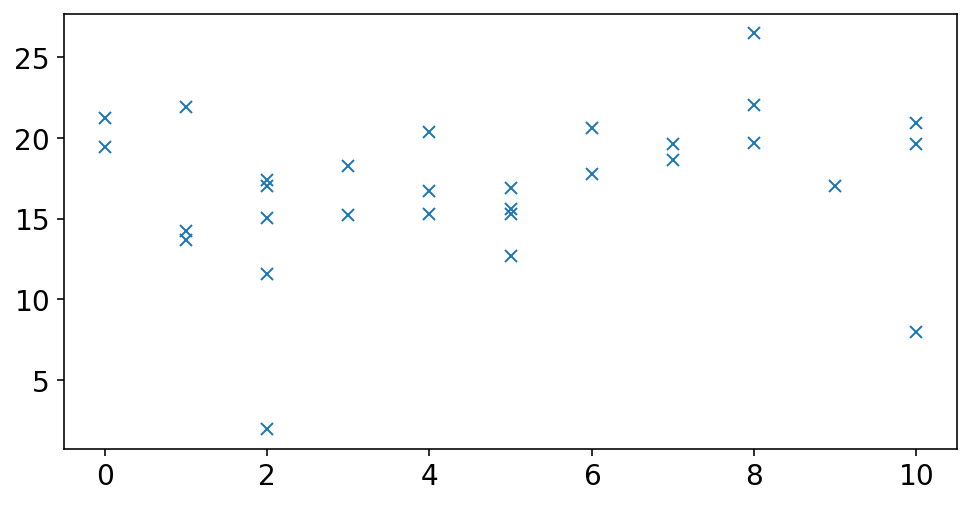

In [69]:
plt.plot(en_idx, np.array(psat_list), linewidth=0, marker='x', label="Psat [GW]")




In [70]:
np.sum(binned_psat)

0.001400680636368495